In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression, DeepKNN,CustomWrapper
from tqdm.notebook import tqdm, trange

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")
plt.style.use('seaborn-darkgrid')

GPU detected is GeForce GTX 970


In [2]:
id_col_db = {'A_C_OF_ALPHA':["sample_id"],
             'A_C_OF_SIWARE':[],
             'A_AL_RT':[],
             'PLN7':["db_id", "sample_id"],
             'mango_684_990': ['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]
            }

output_col_db= {'A_C_OF_ALPHA':None,
             'A_C_OF_SIWARE':None,
             'A_AL_RT':None,
             'PLN7':None,
             'mango_684_990': ['DM']
            }


In [3]:
#setup input and output formats, load data

file_name = "A_C_OF_SIWARE.csv"
dataset_name = re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

file_dir= Path("D:/workspace/lazydeep/experiments/2.04_reverse")/dataset_name #2.04/1.06

In [4]:
scores_cv_db = pd.read_csv(file_dir/"scores.csv")
scores_test_db = pd.read_csv(file_dir/"test_scores.csv")

In [5]:
#order models
deep_set = scores_cv_db[scores_cv_db["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

In [6]:
scores_cv_db_deep = scores_cv_db[scores_cv_db["predictor"]=='deep'].sort_values("R2")
scores_cv_db_knn =scores_cv_db[scores_cv_db["predictor"].str.contains('knn')] 

['knn_tta_n=5' 'knn_ttm_n=5' 'knn_tta_r_n=5' 'knn_ttm_r_n=5'
 'knn_tta_n=10' 'knn_ttm_n=10' 'knn_tta_r_n=10' 'knn_ttm_r_n=10'
 'knn_tta_n=20' 'knn_ttm_n=20' 'knn_tta_r_n=20' 'knn_ttm_r_n=20'
 'knn_tta_n=50' 'knn_ttm_n=50' 'knn_tta_r_n=50' 'knn_ttm_r_n=50'
 'knn_tta_n=100' 'knn_ttm_n=100' 'knn_tta_r_n=100' 'knn_ttm_r_n=100']


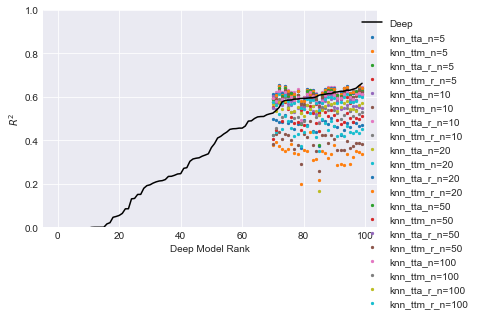

In [7]:
#rank our models on cv_set 

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_cv_db_knn["predictor"].unique()
print(knn_models)
ax.plot(order_models(scores_cv_db_deep["model_num"]), scores_cv_db_deep["R2"], label='Deep',c="black")

for knn_model in knn_models:
    #k = int(knn_model.replace("lwr_k=",""))
    #if k>=100:
        subset = scores_cv_db[scores_cv_db["predictor"]==knn_model]
        ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=5, label=f"{knn_model}")
#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.3, 1))
ax.set_ylabel(r"$R^2$")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
#ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(file_dir/f"prod_cv.png", bbox_inches='tight')

In [8]:
scores_test_db_deep = scores_test_db[scores_test_db["predictor"]=='deep']
scores_test_db_knn =scores_test_db[scores_test_db["predictor"].str.contains('knn')] 

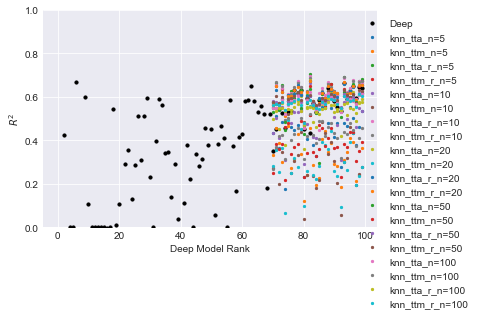

In [9]:
#rank our models on test_set 

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_test_db_knn["predictor"].unique()

ax.scatter(x=order_models(scores_test_db_deep["model_num"]),        y= scores_test_db_deep["R2"],s=10, label='Deep',c="black")
for knn_model in knn_models:
    #k = int(knn_model.replace("lwr_k=",""))
    #if k>=100:
        subset = scores_test_db[scores_test_db["predictor"]==knn_model]
        ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=5, label=f"{knn_model}")

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.3, 1))
ax.set_ylabel(r"$R^2$")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
#ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(file_dir/f"prod_test.png", bbox_inches='tight')

In [10]:
#take our best 30 models 

def filter_db(row,n=30):
    order = deep_ordering[row["model_num"]]
    if order >= (100-n):
        return True
    else:
        return False

inds = scores_cv_db.apply(filter_db,axis=1)
cv_top_30 = scores_cv_db[inds==True]
inds = scores_test_db.apply(filter_db,axis=1)
test_top_30 = scores_test_db[inds==True]

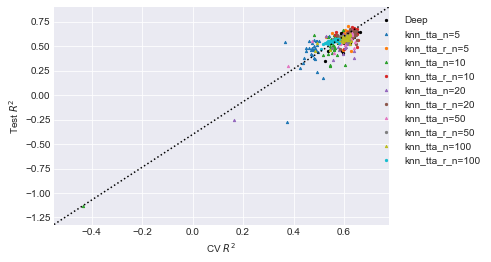

In [11]:
#rank our models on test_set 
from scipy.stats import linregress
from sklearn.metrics import r2_score


fig, ax = plt.subplots()
set_deep = False
predictors = cv_top_30["predictor"].unique()
for predictor in predictors:
    cv_subset = cv_top_30[cv_top_30["predictor"]==predictor]
    test_subset = test_top_30[test_top_30["predictor"]==predictor]
    x=cv_subset["R2"]
    y=test_subset["R2"]
    R2 = r2_score(x,y)
    lin =linregress(x,y)
    if predictor == "deep":
        ax.scatter(x=x, y=y, s=5,c="black",label=f"Deep")  #R2 = {R2:.4f}")
    elif "tta" in predictor:
        #k = int(predictor.replace("lwr_k=",""))
        #if k>=100:
        if "tta_r" in predictor:
            ax.scatter(x=x, y=y, s=5, label=f"{predictor}") #R2 = {R2:.4f}")
        else:
            ax.scatter(x=x, y=y, s=5, label=f"{predictor}",marker="^") #R2 = {R2:.4f}")
# plot residuals
ax.legend(loc='upper right' , bbox_to_anchor=(1.3, 1))
ax.set_xlabel(r"CV $R^2$")
ax.set_ylabel(r"Test $R^2$")
ax.axline([ax.get_xlim()[0], ax.get_ylim()[0]], [ax.get_xlim()[1], ax.get_ylim()[1]],c="black",linestyle=":")
#x.set_ylim(0,0.8)
#ax.set_yscale("symlog")
#ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(file_dir/f"prod_compare_add.png", bbox_inches='tight')

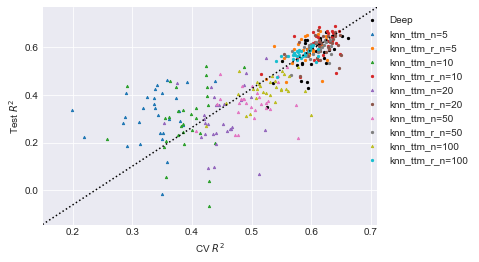

In [12]:
#rank our models on test_set 
from scipy.stats import linregress
from sklearn.metrics import r2_score


fig, ax = plt.subplots()
set_deep = False
predictors = cv_top_30["predictor"].unique()
for predictor in predictors:
    cv_subset = cv_top_30[cv_top_30["predictor"]==predictor]
    test_subset = test_top_30[test_top_30["predictor"]==predictor]
    x=cv_subset["R2"]
    y=test_subset["R2"]
    R2 = r2_score(x,y)
    lin =linregress(x,y)
    if predictor == "deep":
        ax.scatter(x=x, y=y, s=5,c="black",label=f"Deep")  #R2 = {R2:.4f}")
    elif "ttm" in predictor:
        #k = int(predictor.replace("lwr_k=",""))
        #if k>=100:
        if "ttm_r" in predictor:
            ax.scatter(x=x, y=y, s=5, label=f"{predictor}") #R2 = {R2:.4f}")
        else:
            ax.scatter(x=x, y=y, s=5, label=f"{predictor}",marker="^") #R2 = {R2:.4f}")
# plot residuals
ax.legend(loc='upper right' , bbox_to_anchor=(1.3, 1))
ax.set_xlabel(r"CV $R^2$")
ax.set_ylabel(r"Test $R^2$")
ax.axline([ax.get_xlim()[0], ax.get_ylim()[0]], [ax.get_xlim()[1], ax.get_ylim()[1]],c="black",linestyle=":")

#x.set_ylim(0,0.8)
#ax.set_yscale("symlog")
#ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(file_dir/f"prod_compare_mult.png", bbox_inches='tight')

